# Grid Manipulation in KANs

This is the Part 3 of the Tutorial series on KAN. In the previous two parts, we looked at the fundamental components of KANs, focusing on spline activations and performing backpropagation within networks composed of such activation functions.

In this notebook, we will uncover the benefits of KANs. Specifically,

- We will explore how the model's capacity can be expanded easily during training. This flexibility greatly enhances the reusability of models, allowing a previously trained model to be enlarged or pruned while continuing to learn, rather than requiring retraining from scratch.

- We will demonstrate how KANs effectively retain knowledge across diverse input distributions without suffering from catastrophic forgetting. This capability facilitates continual learning, ensuring the model adapts without losing previously acquired knowledge.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions, get_coeff, single_stacked_kan_training

## Section 1: Enhancing model capacity mid-training

To increase the capacity of a KAN without adding more neurons (or splines), you can augment the number of parameters by increasing the number of control points. This involves adjusting the existing grid to accommodate more control points.

**Procedure for Increasing Parameters:**
1. **Adapting Control Points**: The goal is to fit more control points into the existing grid. To achieve this, we utilize a spline that maps standard grid control points, typically ranging from $ [-1, 1] $, to those in the existing grid. We calculate temporary coefficients (`temp_coef`) for this purpose.
2. **Generating More Control Points**: With the mapping spline established, we can predict and generate as many control points as needed within the existing grid.

This approach becomes particularly useful when the existing grid's control points are non-uniformly spaced, as a spline provides a methodical way to interpolate and form new control points. However, other techniques might also be used to extend the grid with additional control points.

In [3]:
k=3
coarse_grid_size = 10
finer_grid_size = 20

preacts = torch.rand((100, 1))
postacts = torch.sin(preacts) + torch.randn(preacts.shape) * 0.1

# find the new control points
prev_grid = torch.linspace(-2.5, 2, steps=coarse_grid_size).unsqueeze(dim=0) # we need to increase the contorl points here

# learn the spline to predict the control points in the existing grid
x_pos = prev_grid.transpose(1,0)
temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1) # linear interpolate into a smaller grid
temp_coef = get_coeff(temp_bases, x_pos)

# let's predict more control points using the above spline
percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0)
new_grid

# find the coefficients (predicitng the same postacts from preacts but using the new control points)
new_bases = eval_basis_functions(preacts, new_grid, k)
new_coef = get_coeff(new_bases, postacts)


Let's put it in a function

In [4]:
def update_grid(prev_grid, new_grid_size, k, preacts, postacts):
    """
    Updates grid.

    Args:
        prev_grid: number of splines x number of control points
        new_grid_size: new number of control points
        k: spline-order
        preacts: inputs to the grid
        postacts: current outputs to the grid. 

    Returns:
        new_coef: New coefficients to maintain the behavior of the current spline-activation
        new_grid: new grid with new control points
    """
    coarse_grid_size = prev_grid.shape[-1]
    finer_grid_size = new_grid_size
    
    # learn the spline to predict the control points in the existing grid
    x_pos = prev_grid.transpose(1,0)
    temp_grid = torch.linspace(-1, 1, steps=coarse_grid_size).unsqueeze(dim=0)
    temp_bases = eval_basis_functions(temp_grid.transpose(1, 0), temp_grid, k=1) # linear interpolate into a smaller grid
    temp_coef = get_coeff(temp_bases, x_pos)
    
    # let's predict more control points using the above spline
    percentiles = torch.linspace(-1, 1, steps=finer_grid_size).unsqueeze(dim=1)
    percentiles_basis = eval_basis_functions(percentiles, temp_grid, k=1)
    new_grid = torch.einsum('ijk, bij-> bk', temp_coef, percentiles_basis).transpose(1, 0)
    
    # find the coefficients (predicitng the same postacts from preacts but using the new control points)
    new_bases = eval_basis_functions(preacts, new_grid, k)
    new_coef = get_coeff(new_bases, postacts)

    return new_coef, new_grid


In [13]:
# fn, fn_label = lambda x: torch.sin(torch.pi * x),  '$sin(\pi x)$'
# fn, fn_label = (lambda x: torch.exp(torch.exp(-x)) + torch.sin(torch.pi * x) + torch.exp(torch.sin(x)), '$e^{e^{-x}} + sin(\pi \cdot x) + e^{sin(x)}$')
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')

x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]


lr = 0.1
k = 2
n_layers = 1
grid_sizes = [3]
grid_range = [-1, 1]

loss_batches = []

params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                         k=k, n_layers=n_layers, 
                                                                         grid_sizes=grid_sizes, verbose=False, 
                                                                         grid_range=[], use_scales=False)
loss_batches.append(losses_kan)

for new_grid_size in [5, 8, 10, 12]:    
    prev_grid = params_kan['grids'][0]
    prev_coef = params_kan['coeffs'][0]
    postacts = all_xs[-1][0]
    new_coef, new_grid = update_grid(prev_grid, new_grid_size, k, x_training, postacts)
    
    new_coef = new_coef.requires_grad_(True)
    params_kan['grids'] = [new_grid]
    params_kan['coeffs'] = [new_coef]

    print(f"Increasing number of parameters to {new_grid_size}: Prev grid: {prev_grid.shape} New grid: {new_grid.shape} Prev. Coef: {prev_coef.shape} New Coef: {new_coef.shape}")

    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, model_params=params_kan, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=[], use_scales=False)


    loss_batches.append(losses_kan)


Stopping: No further improvements...
Increasing number of parameters to 5: Prev grid: torch.Size([1, 3]) New grid: torch.Size([1, 5]) Prev. Coef: torch.Size([1, 4, 1]) New Coef: torch.Size([1, 6, 1])
Stopping: No further improvements...
Increasing number of parameters to 8: Prev grid: torch.Size([1, 5]) New grid: torch.Size([1, 8]) Prev. Coef: torch.Size([1, 6, 1]) New Coef: torch.Size([1, 9, 1])
Stopping: No further improvements...
Increasing number of parameters to 10: Prev grid: torch.Size([1, 8]) New grid: torch.Size([1, 10]) Prev. Coef: torch.Size([1, 9, 1]) New Coef: torch.Size([1, 11, 1])
Stopping: No further improvements...
Increasing number of parameters to 12: Prev grid: torch.Size([1, 10]) New grid: torch.Size([1, 12]) Prev. Coef: torch.Size([1, 11, 1]) New Coef: torch.Size([1, 13, 1])
Stopping: No further improvements...


Text(0.5, 1.0, 'Loss:\n$f(x) = e^{sin(\\pi x) + x^2} + \\frac{1}{1+x^2}$')

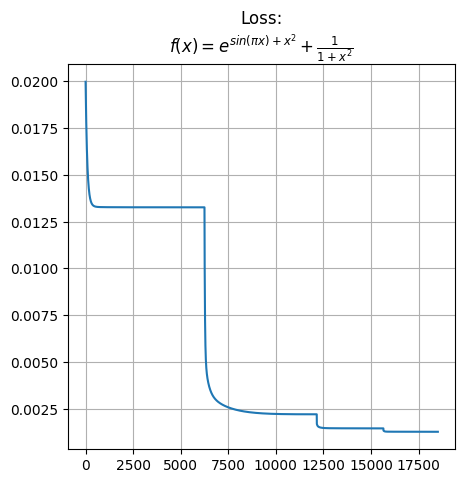

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)

ax = axs 
ax.plot([x for losses in loss_batches for x in losses['val'] if x < 0.02])
ax.grid()
ax.set_title(f"Loss:\n{fn_label}")

**Obseravtions:** 

With every expansion in model capacity, we observe an increase in the generalization power of the [1, 1] KAN.

## Section 2: Continual Learning

In continual learning, the domain of inputs changes over time. In traditional deep learning models, using data from a new task as training data often leads to "catastrophic forgetting," where the network begins to forget previously learned tasks. KANs effectively overcome this issue. The reason lies in their use of B-splines as activation functions. B-splines exhibit a property of locality, meaning that adjustments to specific points can be made without affecting the global curve. This feature is crucial in KAN activation functions, allowing them to adapt to new input domains seamlessly while preserving their behavior in previous contexts.

Let's explore this capability in practice...

First, we will wrap our KAN prediction in a function to avoid code repetition. 

In [15]:
def model_predict(params_kan, x_eval, k):
    """
    Implements prediction functions using raw KANs. 
    """
    grids = params_kan['grids']
    coeffs = params_kan['coeffs']
    scale_bases = params_kan['scale_bases']
    scale_splines = params_kan['scale_splines']
    base_fns = params_kan['base_fns']
    
    for idx in range(len(grids)):
        grid, coeff = grids[idx], coeffs[idx]
        
        with torch.no_grad():
            x = torch.einsum('ijk, bij -> bk', coeff, eval_basis_functions(x_eval, grid, k))
            if len(base_fns) > 0:
                base_fn, scale_sp, scale_base =  base_fns[idx], scale_splines[idx], scale_bases[idx]
                x = scale_base * base_fn(x_eval) + scale_sp * x
                
        y_pred = x_eval = x
        
    
    return y_pred

We will create a dataset that exhibits different functional forms over varying input ranges. The challenge is to train a [1, 1] KAN on this dataset in a task-by-task manner, where observations from each task are presented sequentially rather than all at once.

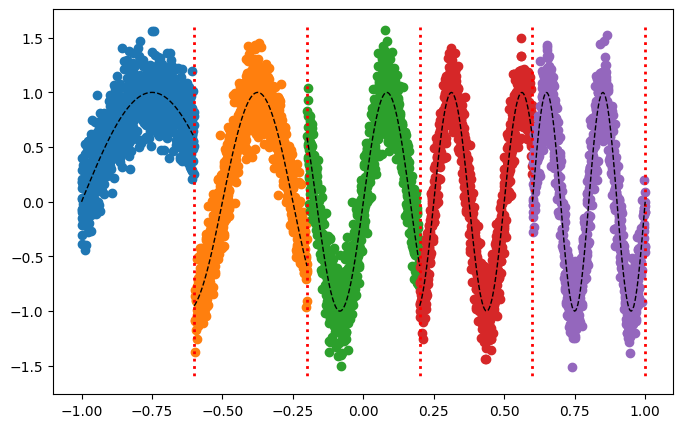

In [16]:
# Set random seed for reproducibility
torch.random.manual_seed(42)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# Data generation parameters
n_samples_per_phase = 1000
noise_level = 0.2
n_phases = 5

for i in range(n_phases):
    start = -1 + i * 2/n_phases
    end = start + 2/n_phases
    x = torch.rand(n_samples_per_phase) * (end - start) + start
    
    y = torch.sin(2 * x * torch.pi * (i + 1)) 
    y_noisy = y + noise_level * torch.randn(y.shape)

    ax.scatter(x, y_noisy)
    ax.vlines(end, 1.6, -1.6, color='red', linestyle=':', linewidth=2)

    x_ = torch.linspace(start, end, 100)
    y_ = torch.sin(2 * x_ * torch.pi * (i + 1))
    ax.plot(x_, y_, color='black', linewidth=1, linestyle='--')
    

Let's prepare the dataset to train the KAN parameters. We will consider a scenario involving three tasks, each represented by a dataset with a distinct functional form defined over separate input domains.

Stopping: No further improvements...
Phase: 0	Loss:  0.0482
Stopping: No further improvements...
Phase: 1	Loss:  0.0651
Stopping: No further improvements...
Phase: 2	Loss:  0.0616


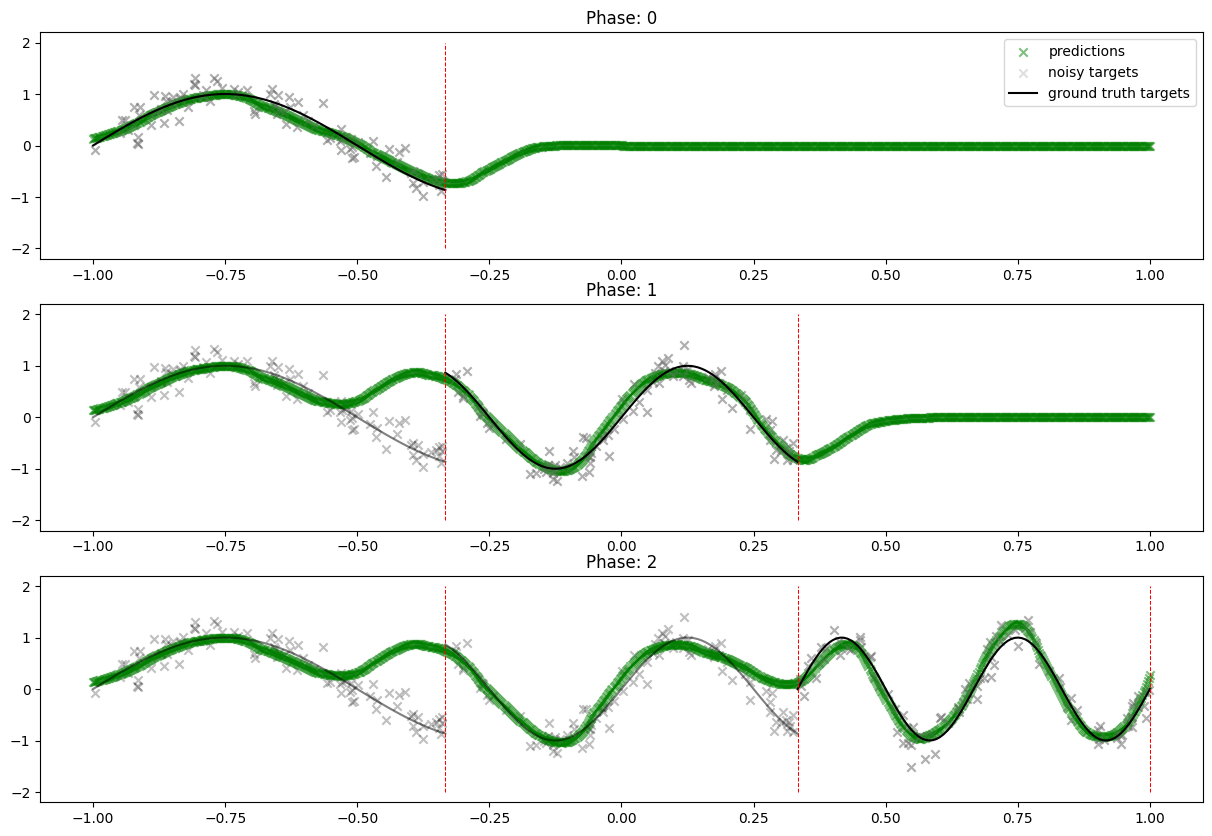

In [24]:
# Data generation parameters
n_samples_per_phase = 100
noise_level = 0.2
n_phases = 3

fig, axs = plt.subplots(nrows=n_phases, ncols=1, figsize=(15, 10), dpi=100)

losses = []
grid_sizes = [20]
grid_range = [-1, 1]
lr = 0.5
k = 3
n_layers = 1

params_kan = None
x_temps, y_temps, ends, y_noisys = [], [], [], []
for i in range(n_phases):

    # create this dataset
    start = -1 + i * 2/n_phases
    end = start + 2/n_phases
    fn = lambda x, i: torch.sin(2 * x * torch.pi * (i + 1))
    
    x = torch.rand(n_samples_per_phase) * (end - start) + start
    
    y = fn(x, i)
    y_noisy = y + noise_level * torch.randn(y.shape)

    # train the model
    x_eval = x.unsqueeze(dim=1)
    y_target = y_noisy.unsqueeze(dim=1)

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    # train using the same model (model_params=params_kan)
    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, model_params=params_kan, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=[], use_scales=False)

    losses.append(losses_kan)
    print(f"Phase: {i}\tLoss: {np.mean(losses_kan['val'][-50:]): 0.4f}")

    # predictions vs target
    ax = axs[i]
    ax.scatter(x, y_noisy, color='black', marker='x', alpha=0.25)
    for temp_x, temp_y in y_noisys:
        ax.scatter(temp_x, temp_y, color='black', alpha=0.25, marker='x')

    y_noisys.append((x, y_noisy))


    x_in = torch.linspace(-1, 1, 1000).unsqueeze(dim=1)
    y_pred = model_predict(params_kan, x_in, k)
    ax.scatter(x_in[:, 0], y_pred, color='green', alpha=0.5, marker='x', label="predictions")
    ax.scatter(x, y_noisy, color='grey', marker='x', alpha=0.25, label="noisy targets")

    x_temp = torch.linspace(0, 1, 100) * (end - start) + start
    y_temp = fn(x_temp, i)
    
    ax.plot(x_temp, y_temp, linestyle='-',  color='black', label="ground truth targets")
    for x,y in zip(x_temps, y_temps):
        ax.plot(x, y, linestyle='-', alpha=0.5, color='black')

    ends.append(end)
    for x in ends:
        ax.vlines(x, -2, 2, linestyle='--', color='red', linewidth=0.75)

    ax.set_title(f"Phase: {i}")
    if i == 0:
        ax.legend()

    x_temps.append(x_temp)
    y_temps.append(y_temp)
    

**Observations:**

The green points indicate the predictions of the learned KAN. As observed in successive phases of the dataset, the function learned from previous input domains is retained. This consistency allows for continual learning without catastrophic forgetting.

### Summary

In this session, we explored how the grid in B-splines can be utilized effectively to enhance model capacity without the need to retrain models. We also examined how these grids help prevent catastrophic forgetting in continual learning scenarios.

### What's next?

In the next notebook, we will explore how to perform symbolic learning using KANs.